# Imports and Helper Functions:

In [1]:
# Import packages
# DL Packages
import tensorflow as tf
import keras

# Others
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import sympy as sym
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

2023-12-10 21:34:39.270115: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 21:34:39.292233: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 21:34:39.292253: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 21:34:39.292269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 21:34:39.296329: I tensorflow/core/platform/cpu_feature_g

In [2]:

def plot_confusion_matrix(Y: np.array, pred: np.array, labels=[], savename="", logscale=False, title="Confustion Matrix"):
    """
    Convenience function for generating a confusion Matrix

    Args:
        Y (np.array): Actual labels for the dataset (n rows, 1 column)
        pred (np.array): Predicted labels for the data (n rows, 1 column)
        labels (list of str): class labels
        savename (str, optional): File to save plot to. If none is given shows figure.
                                    Defaults to "".

    Returns:
        confusion matrix
    """
    # Figure out predicted class -- infer from Y and pred the number of classes
    if Y.shape[1] > 1:
        Y_labels = np.zeros(Y.shape[0], dtype=int)
        pred_labels = np.zeros_like(Y_labels)
        for i in range(Y.shape[0]):
            Y_labels[i] = np.argmax(Y[i])
            pred_labels[i] = np.argmax(pred[i])
    else:
        Y_labels = Y
        pred_labels = (Y >= 0.5).astype(int)
    cm = confusion_matrix(Y_labels, pred_labels)
    f, ax = plt.subplots()
    if logscale:
        from matplotlib.colors import LogNorm, Normalize
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', norm=LogNorm())
    else:
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    # labels, title and ticks
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title(title)
    if not labels:
        labels = np.arange(max(Y.shape[1], 2))
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    if savename != "":
        plt.savefig(savename)
        plt.close(f)
    else:
        f.set_size_inches((8,8))
        plt.tight_layout()
        plt.show()
        
    return cm

# Examine and Preprocess the Data:

## Examine Data

In [3]:
data = pd.read_csv("Final_News_DF_Labeled_ExamDataset.csv")
data

,LABEL,according,agency,ahead,alabama,amazon,america,american,announced,appeared,...,wolverines,women,work,working,world,wrote,year,years,york,young
0,politics,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,politics,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,politics,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,politics,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,politics,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,science,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1489,science,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1490,science,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1491,science,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each entry is labeled by a catergory of article, with the columns representing words that appeared or not

In [4]:
data.groupby("LABEL").size()

LABEL
football    500
politics    497
science     496
dtype: int64

fewest words present 0
most words present 17


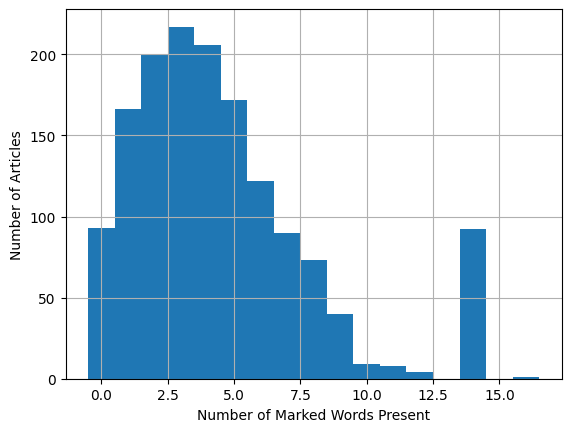

In [5]:
nwords_present = data[[c for c in data.columns if c != "LABEL"]].sum(axis=1)
print("fewest words present", nwords_present.min())
print("most words present", nwords_present.max())
nwords_present.hist(bins=nwords_present.max()-nwords_present.min(),align="left")
plt.ylabel("Number of Articles")
plt.xlabel("Number of Marked Words Present");

The data is pretty sparse, meaning almost all articles have fewer than 10 marked words.

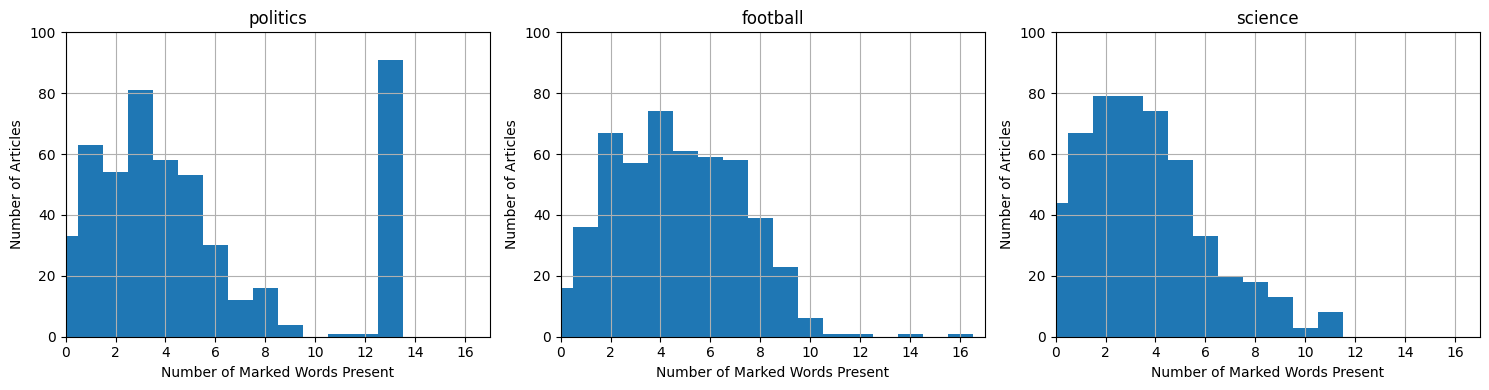

In [6]:
f, ax = plt.subplots(ncols=3)
f.set_size_inches((15,4))

for i, label in enumerate(data.LABEL.unique()):
    nwords_present = data[data.LABEL == label][[c for c in data.columns if c != "LABEL"]].sum(axis=1)
    ax[i].hist(x = nwords_present.values, bins=nwords_present.max()-nwords_present.min(),align="left")
    ax[i].grid()
    ax[i].set_ylabel("Number of Articles")
    ax[i].set_xlabel("Number of Marked Words Present");
    ax[i].set_title(label)
    ax[i].set_xlim(0,17)
    ax[i].set_ylim(0,100)

plt.tight_layout();

## Preprocess Data

Turn it into data matrix X and label vector Y. X is already OHE, while Y needs to be turned into OHE.

In [7]:
X = data[[c for c in data.columns if c != "LABEL"]].to_numpy()
Y_raw = data["LABEL"].to_numpy()

# Do the OHE
vals = np.unique(Y_raw)
val_map = {}
for i, v in enumerate(vals):
    val_map[v] = i
Y = np.zeros((Y_raw.shape[0], len(val_map)), dtype=int)
for i in range(Y.shape[0]):
    Y[i, val_map[Y_raw[i]]] = 1

print("val_map", val_map)
print("X shape:", X.shape)
print("X:\n", X)
print("Y shape:", Y.shape)
print("Y:\n", Y)

val_map {'football': 0, 'politics': 1, 'science': 2}
X shape: (1493, 300)
X:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Y shape: (1493, 3)
Y:
 [[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


Preprocessing looks good. The data is balanced, with an approximately equal number of entries from each class. As it did not come with a specified train/test split, I'll do my own n-fold cross validation. As there are approximately 500 in each class, I'll do 5 fold to get about 100 of each in each test set.

In [8]:
splits = KFold(n_splits=5, shuffle=True, random_state=7)

Let's look at the balance of the splits to make sure it worked:

In [9]:
fold = 1
for train, test in splits.split(X, Y_raw):
    print("---------------------------")
    print("FOLD:", fold)
    print("TRAIN:", np.unique(Y_raw[train], return_counts=True))
    print("TEST:", np.unique(Y_raw[test], return_counts=True))
    fold += 1

---------------------------
FOLD: 1
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([400, 391, 403]))
TEST: (array(['football', 'politics', 'science'], dtype=object), array([100, 106,  93]))
---------------------------
FOLD: 2
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([402, 396, 396]))
TEST: (array(['football', 'politics', 'science'], dtype=object), array([ 98, 101, 100]))
---------------------------
FOLD: 3
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([402, 402, 390]))
TEST: (array(['football', 'politics', 'science'], dtype=object), array([ 98,  95, 106]))
---------------------------
FOLD: 4
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([393, 404, 398]))
TEST: (array(['football', 'politics', 'science'], dtype=object), array([107,  93,  98]))
---------------------------
FOLD: 5
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([403, 395, 397]))
TEST: (array([

Folds are looking balanced, let's move ahead with making some models after defining some helpers for the folding:

In [10]:
def train_on_folds(model_fn, splits, X, Y, epochs=100, batch_size=2000):

    models = []
    histories = []

    # Train a different model for each fold
    for fold_n, (train, test) in enumerate(splits.split(X, Y)):

        print("-----------------")
        print("Training on fold", fold_n)

        X_train = X[train]
        Y_train = Y[train]

        X_test = X[test]
        Y_test = Y[test]
        
        model = model_fn()
        history = model.fit(X_train, Y_train, epochs=epochs, validation_data = (X_test, Y_test))

        models.append(model)
        histories.append(history)

    return models, histories

def pred_on_folds(models, splits, X, Y):

    Y_pred = np.zeros_like(Y, dtype=float)
    for fold_n, (train, test) in enumerate(splits.split(X, Y)):
        preds = models[fold_n].predict(X[test])
        Y_pred[test] = preds
    
    return Y_pred

# ANN Model:

I honestly don't think there's too much information in the tokenization as is. I think the best we'll be able to do is to essentially find that statistically some combinations of words appear more often in certain types of articles than others. With more data maybe or some transfer learning maybe we could do more.

For the ANN model I will I will include just one small hidden layer before the softmax:

## Define and Train

In [11]:
def ann_model(input_size=X.shape[1], output_size=Y.shape[1], optimizer="adam", loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy()]):

    model = keras.models.Sequential([
                keras.layers.Input(input_size),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(2*output_size, activation="sigmoid"),
                keras.layers.Dense(output_size, activation="softmax")
            ])
    
    model.build(input_size)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

ann_test = ann_model()
ann_test.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 6)                 1806      
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
Total params: 1827 (7.14 KB)
Trainable params: 1827 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-10 21:34:41.294099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 21:34:41.297310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 21:34:41.297403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
models_ann, histories_ann = train_on_folds(ann_model, splits, X, Y, epochs=60)
pred_ann = pred_on_folds(models_ann, splits, X, Y)


-----------------
Training on fold 0
Epoch 1/60


2023-12-10 21:34:41.854673: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/38 [..............................] - ETA: 29s - loss: 1.1948 - categorical_accuracy: 0.4062

2023-12-10 21:34:42.159061: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f07a02b3f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-10 21:34:42.159079: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2023-12-10 21:34:42.162069: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-10 21:34:42.170000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-10 21:34:42.209930: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 [==============================] - 1s 4ms/step - loss: 1.1236 - categorical_accuracy: 0.3928 - val_loss: 1.0802 - val_categorical_accuracy: 0.4582
Epoch 2/60
38/38 [==============================] - 0s 2ms/step - loss: 1.0772 - categorical_accuracy: 0.4263 - val_loss: 1.0471 - val_categorical_accuracy: 0.4916
Epoch 3/60
38/38 [==============================] - 0s 2ms/step - loss: 1.0467 - categorical_accuracy: 0.4590 - val_loss: 1.0227 - val_categorical_accuracy: 0.5084
Epoch 4/60
38/38 [==============================] - 0s 2ms/step - loss: 1.0229 - categorical_accuracy: 0.5352 - val_loss: 1.0029 - val_categorical_accuracy: 0.5920
Epoch 5/60
38/38 [==============================] - 0s 2ms/step - loss: 1.0018 - categorical_accuracy: 0.6281 - val_loss: 0.9848 - val_categorical_accuracy: 0.6656
Epoch 6/60
38/38 [==============================] - 0s 2ms/step - loss: 0.9827 - categorical_accuracy: 0.6734 - val_loss: 0.9665 - val_categorical_accuracy: 0.6957
Epoch 7/60
38/38 [=========

## Confusion Matrix

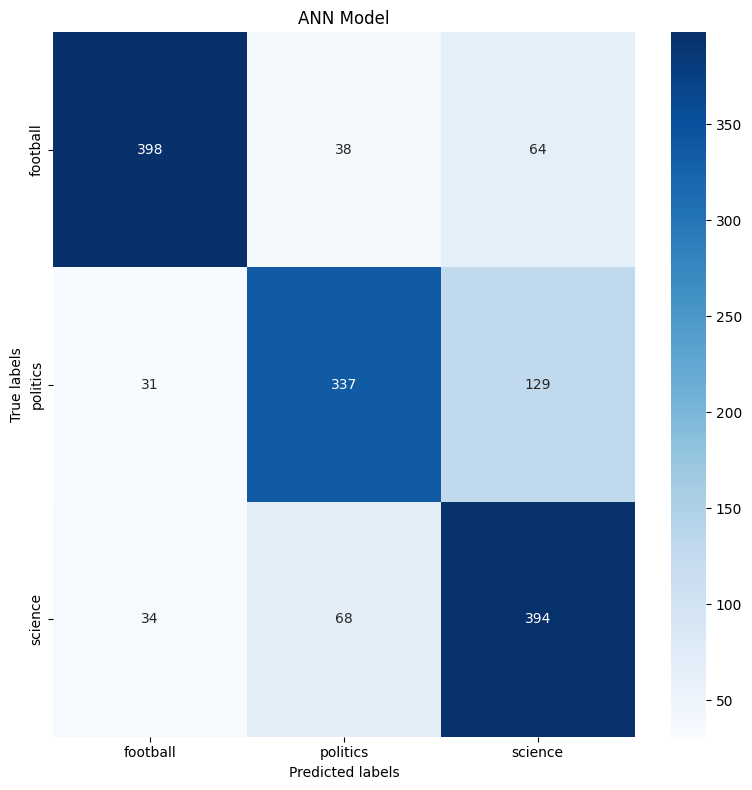

array([[398,  38,  64],
       [ 31, 337, 129],
       [ 34,  68, 394]])

In [13]:
plot_confusion_matrix(Y, pred_ann, labels=list(vals), logscale=False, title="ANN Model")

## Training History

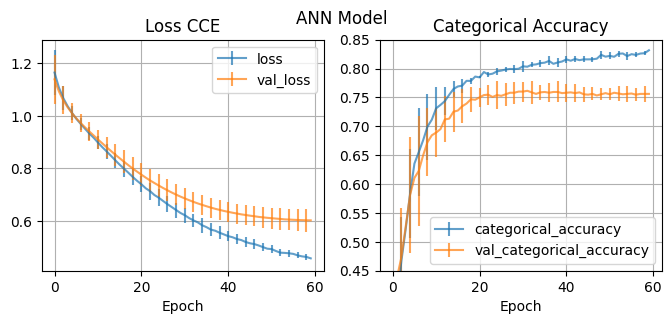

In [31]:
def get_mean_std(histories, key):
    vals = np.array([h.history[key] for h in histories])
    return np.mean(vals, axis=0), np.std(vals, axis=0)

def plot_key(ax, x_vals, histories, key, errorevery=1):
    mean, std = get_mean_std(histories, key)
    ax.errorbar(x_vals, mean, std, label=key, errorevery=errorevery, alpha=0.7)


f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
epochs = np.arange(len(histories_ann[0].history["loss"]))
every_n = 2
plot_key(ax[0], epochs, histories_ann, "loss", errorevery=every_n)
plot_key(ax[0], epochs, histories_ann, "val_loss", errorevery=every_n)
plot_key(ax[1], epochs, histories_ann, "categorical_accuracy", errorevery=every_n)
plot_key(ax[1], epochs, histories_ann, "val_categorical_accuracy", errorevery=every_n)
ax[0].set_title("Loss CCE")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[0].grid()
plt.suptitle("ANN Model")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Categorical Accuracy")
ax[1].grid()
ax[1].set_ylim(0.45, 0.85)
ax[1].legend();

# CNN Model:

## Define and Train

In [15]:
def cnn_model(embedding_size=32, input_size=X.shape[1], output_size=Y.shape[1], optimizer="adam", loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy()]):

    model = keras.models.Sequential([
                # This initial dense layer serves as an embedding layer
                keras.layers.Input(input_size),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(embedding_size),
                keras.layers.Reshape((embedding_size, 1)),
                # keras.layers.Reshape((input_size, 1)),
                
                # Now begin the convolutional part
                keras.layers.Conv1D(filters=embedding_size, kernel_size=3, strides=1, padding="same", activation="relu"),
                keras.layers.MaxPool1D(pool_size=2),
                keras.layers.Conv1D(filters=embedding_size/4, kernel_size=3, strides=1, padding="same", activation="relu"),
                keras.layers.MaxPool1D(pool_size=2),
                keras.layers.Flatten(),
                keras.layers.Dense(output_size, activation="softmax")
            ])
    
    model.build(input_size)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

cnn_test = cnn_model()
cnn_test.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                9632      
                                                                 
 reshape (Reshape)           (None, 32, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 8)             776       
                                                      

In [43]:
models_cnn, histories_cnn = train_on_folds(cnn_model, splits, X, Y, epochs=7)
pred_cnn = pred_on_folds(models_cnn, splits, X, Y)


-----------------
Training on fold 0
Epoch 1/7
38/38 [==============================] - 1s 4ms/step - loss: 1.0716 - categorical_accuracy: 0.4806 - val_loss: 1.0217 - val_categorical_accuracy: 0.4716
Epoch 2/7
38/38 [==============================] - 0s 2ms/step - loss: 0.9793 - categorical_accuracy: 0.5637 - val_loss: 0.8982 - val_categorical_accuracy: 0.6388
Epoch 3/7
38/38 [==============================] - 0s 2ms/step - loss: 0.7943 - categorical_accuracy: 0.7178 - val_loss: 0.6874 - val_categorical_accuracy: 0.7090
Epoch 4/7
38/38 [==============================] - 0s 2ms/step - loss: 0.5879 - categorical_accuracy: 0.7789 - val_loss: 0.5886 - val_categorical_accuracy: 0.7525
Epoch 5/7
38/38 [==============================] - 0s 2ms/step - loss: 0.4864 - categorical_accuracy: 0.8032 - val_loss: 0.5689 - val_categorical_accuracy: 0.7692
Epoch 6/7
38/38 [==============================] - 0s 2ms/step - loss: 0.4524 - categorical_accuracy: 0.8157 - val_loss: 0.5634 - val_categorical_ac

## Confusion Matrix

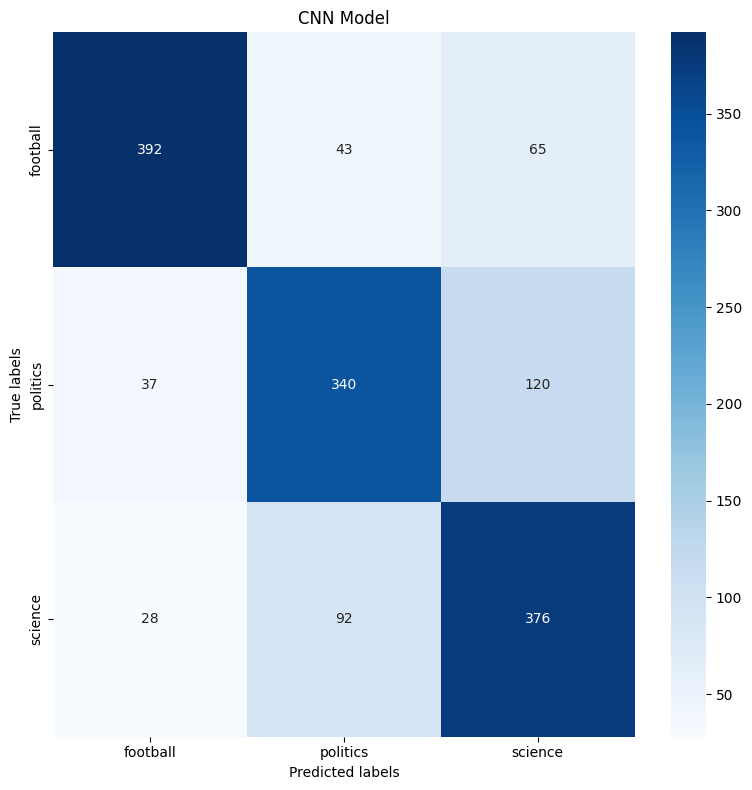

array([[392,  43,  65],
       [ 37, 340, 120],
       [ 28,  92, 376]])

In [44]:
plot_confusion_matrix(Y, pred_cnn, labels=list(vals), logscale=False, title="CNN Model")

## Training History

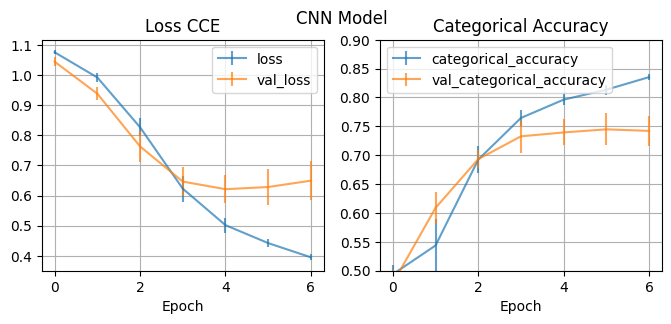

In [45]:
f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
epochs = np.arange(len(histories_cnn[0].history["loss"]))
plot_key(ax[0], epochs, histories_cnn, "loss")
plot_key(ax[0], epochs, histories_cnn, "val_loss")
plot_key(ax[1], epochs, histories_cnn, "categorical_accuracy")
plot_key(ax[1], epochs, histories_cnn, "val_categorical_accuracy")
ax[0].set_title("Loss CCE")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[0].grid()
ax[1].set_xlabel("Epoch")
ax[1].set_title("Categorical Accuracy")
ax[1].set_ylim(0.5, 0.9)
plt.suptitle("CNN Model")
ax[1].grid()
ax[1].legend();

# LSTM Model

## Define and Train

For the LSTM, I'm going to try treating the binary vector as a time series:

In [29]:
num_words = X.shape[1]
X_seq = []
for i in range(X.shape[0]):
    X_seq += [np.nonzero(X[i])[0]+2]

max_len = max([len(x) for x in X_seq])

for i in range(X.shape[0]):
    X_seq[i] = np.pad(X_seq[i], (0, max_len - len(X_seq[i])), 'constant', constant_values=(0, 0))

X_seq = np.array(X_seq)
X_seq, X_seq.shape

(array([[  9,  30,  95, ...,   0,   0,   0],
        [ 63, 117, 165, ...,   0,   0,   0],
        [231,   0,   0, ...,   0,   0,   0],
        ...,
        [ 79,  81, 178, ...,   0,   0,   0],
        [ 82,  93, 111, ...,   0,   0,   0],
        [235,   0,   0, ...,   0,   0,   0]]),
 (1493, 15))

Because there isn't really a temporal relationship here, and coming before is the same as coming after, I will use a bidirectional LSTM.

In [20]:
def lstm_model(lstm_size=8, input_size=X.shape[1], output_size=Y.shape[1], optimizer="adam", loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy()]):

    model = keras.models.Sequential([
                # keras.layers.Input((max_len, 1))
                keras.layers.Embedding(input_dim=num_words+2, output_dim=lstm_size, mask_zero=True),
                keras.layers.Reshape((max_len, lstm_size)),
                keras.layers.Dropout(0.1),
                # keras.layers.Dense(lstm_size),,
                keras.layers.Bidirectional(keras.layers.LSTM(lstm_size, return_sequences=False)),
                # keras.layers.Dense(lstm_size/4, activation="relu"),
                keras.layers.Dense(output_size, activation="softmax")
            ])
    
    model.build(input_size)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

lstm_test = lstm_model()
lstm_test.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           2416      
                                                                 
 reshape_6 (Reshape)         (None, 15, 8)             0         
                                                                 
 dropout_12 (Dropout)        (None, 15, 8)             0         
                                                                 
 bidirectional (Bidirection  (None, 16)                1088      
 al)                                                             
                                                                 
 dense_24 (Dense)            (None, 3)                 51        
                                                                 
Total params: 3555 (13.89 KB)
Trainable params: 3555 (13.89 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [21]:
models_lstm, histories_lstm = train_on_folds(lstm_model, splits, X_seq, Y, epochs=15)
pred_lstm = pred_on_folds(models_lstm, splits, X_seq, Y)

-----------------
Training on fold 0
Epoch 1/15
38/38 [==============================] - 3s 43ms/step - loss: 1.0935 - categorical_accuracy: 0.3978 - val_loss: 1.0831 - val_categorical_accuracy: 0.4247
Epoch 2/15
38/38 [==============================] - 1s 18ms/step - loss: 1.0668 - categorical_accuracy: 0.4581 - val_loss: 1.0270 - val_categorical_accuracy: 0.5886
Epoch 3/15
38/38 [==============================] - 1s 15ms/step - loss: 0.9870 - categorical_accuracy: 0.6106 - val_loss: 0.8895 - val_categorical_accuracy: 0.6120
Epoch 4/15
38/38 [==============================] - 1s 16ms/step - loss: 0.7888 - categorical_accuracy: 0.6415 - val_loss: 0.7094 - val_categorical_accuracy: 0.7023
Epoch 5/15
38/38 [==============================] - 0s 8ms/step - loss: 0.6717 - categorical_accuracy: 0.7320 - val_loss: 0.6699 - val_categorical_accuracy: 0.7124
Epoch 6/15
38/38 [==============================] - 0s 6ms/step - loss: 0.6180 - categorical_accuracy: 0.7521 - val_loss: 0.6682 - val_cate

## Confusion Matrix

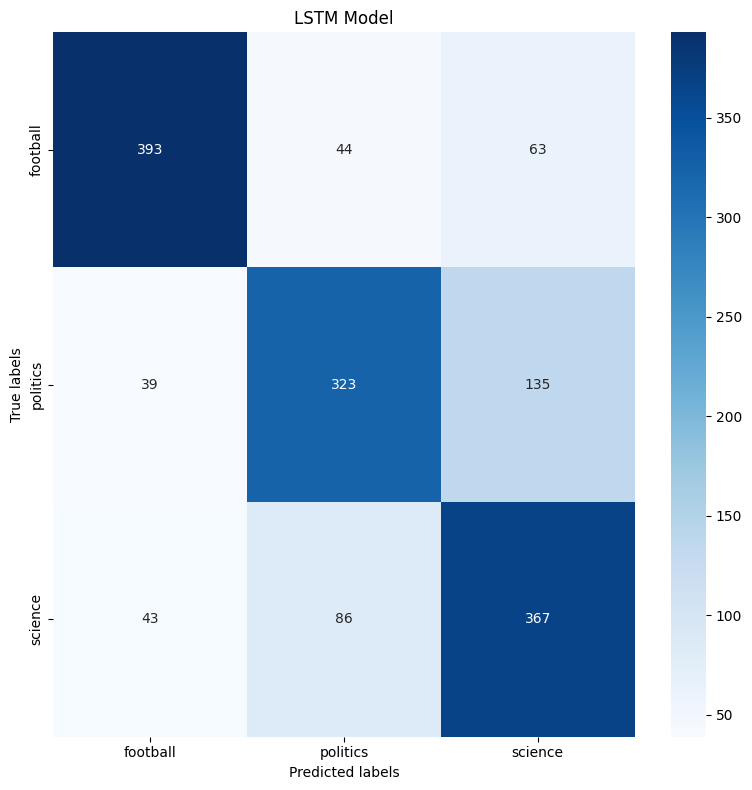

array([[393,  44,  63],
       [ 39, 323, 135],
       [ 43,  86, 367]])

In [22]:
plot_confusion_matrix(Y, pred_lstm, labels=list(vals), logscale=False, title="LSTM Model")

## Training History

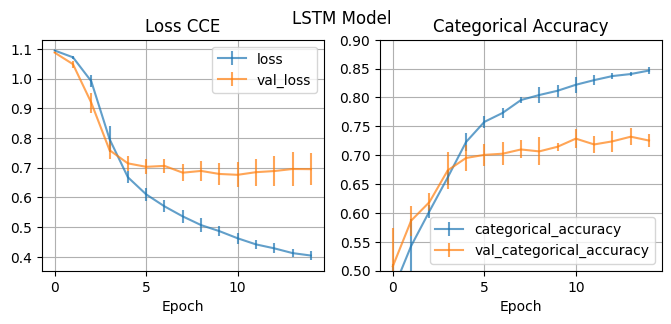

In [42]:
f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
epochs = np.arange(len(histories_lstm[0].history["loss"]))
plot_key(ax[0], epochs, histories_lstm, "loss")
plot_key(ax[0], epochs, histories_lstm, "val_loss")
plot_key(ax[1], epochs, histories_lstm, "categorical_accuracy")
plot_key(ax[1], epochs, histories_lstm, "val_categorical_accuracy")
ax[0].set_title("Loss CCE")
ax[0].set_xlabel("Epoch")
ax[0].grid()
ax[0].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_title("Categorical Accuracy")
ax[1].grid()
ax[1].set_ylim(0.5, 0.9)
plt.suptitle("LSTM Model")
ax[1].legend();

# With GLOVE

In [24]:
import os
path_to_glove_file = "../assignment_3_keras_tf/glove.6B.50d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

num_words = X.shape[1]
num_tokens = num_words + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
words = [c for c in data.columns if c != "LABEL"]
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(words):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < num_tokens:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        print(word, "was a miss")
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
informationen was a miss
lesen was a miss
openai was a miss
Converted 297 words (3 misses)


In [25]:
embedding_matrix.shape

(302, 50)

## Make Input Data:

make vectors containing all the words in the sequence

## Define and Train

In [26]:
def model_glove(embedding_size=50, output_size=Y.shape[1], optimizer="adam", loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy()]):

    model = keras.models.Sequential([
                # This initial dense layer serves as an embedding layer
                keras.layers.Embedding(input_dim=num_words+2, output_dim=embedding_size,
                                        mask_zero=True,
                                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                        trainable=False),
                # LSTM
                keras.layers.Reshape((max_len, embedding_size)),
                keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=False)),
                
                # CNN
                # keras.layers.Reshape((embedding_size, max_len)),
                # keras.layers.Reshape((max_len, embedding_size)),
                # keras.layers.Conv1D(8, kernel_size=3),
                # keras.layers.MaxPool1D(2),
                # keras.layers.Conv1D(4, kernel_size=3),
                # keras.layers.MaxPool1D(2),
                # keras.layers.Flatten(),

                keras.layers.Dense(output_size, activation="softmax")
            ])
    
    
    model.build(num_words + 2)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

cnn_test_glove = model_glove()
cnn_test_glove.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 50)          15100     
                                                                 
 reshape_12 (Reshape)        (None, 15, 50)            0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 32)                8576      
 onal)                                                           
                                                                 
 dense_30 (Dense)            (None, 3)                 99        
                                                                 
Total params: 23775 (92.87 KB)
Trainable params: 8675 (33.89 KB)
Non-trainable params: 15100 (58.98 KB)
_________________________________________________________________


In [27]:
models_glove, histories_glove = train_on_folds(model_glove, splits, X_seq, Y, epochs=40)
pred_lstm = pred_on_folds(models_glove, splits, X_seq, Y)

-----------------
Training on fold 0
Epoch 1/40
38/38 [==============================] - 2s 11ms/step - loss: 1.0943 - categorical_accuracy: 0.3987 - val_loss: 1.0433 - val_categorical_accuracy: 0.4181
Epoch 2/40
38/38 [==============================] - 0s 3ms/step - loss: 1.0264 - categorical_accuracy: 0.4757 - val_loss: 0.9918 - val_categorical_accuracy: 0.5217
Epoch 3/40
38/38 [==============================] - 0s 3ms/step - loss: 0.9790 - categorical_accuracy: 0.5117 - val_loss: 0.9444 - val_categorical_accuracy: 0.5284
Epoch 4/40
38/38 [==============================] - 0s 3ms/step - loss: 0.9324 - categorical_accuracy: 0.5452 - val_loss: 0.9118 - val_categorical_accuracy: 0.5385
Epoch 5/40
38/38 [==============================] - 0s 3ms/step - loss: 0.8917 - categorical_accuracy: 0.5704 - val_loss: 0.8876 - val_categorical_accuracy: 0.5819
Epoch 6/40
38/38 [==============================] - 0s 3ms/step - loss: 0.8668 - categorical_accuracy: 0.5821 - val_loss: 0.8622 - val_categor

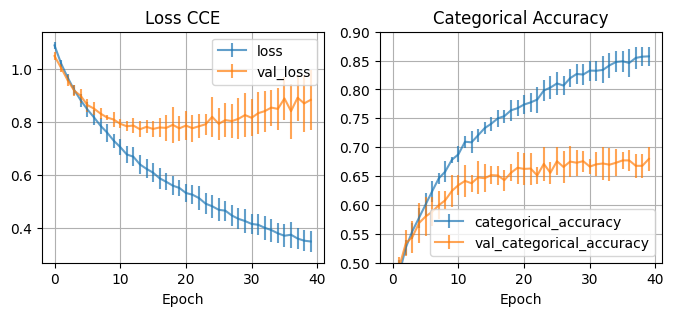

In [46]:
f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
epochs = np.arange(len(histories_glove[0].history["loss"]))
plot_key(ax[0], epochs, histories_glove, "loss")
plot_key(ax[0], epochs, histories_glove, "val_loss")
plot_key(ax[1], epochs, histories_glove, "categorical_accuracy")
plot_key(ax[1], epochs, histories_glove, "val_categorical_accuracy")
ax[0].set_title("Loss CCE")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[0].grid()
ax[1].set_xlabel("Epoch")
ax[1].set_title("Categorical Accuracy")
ax[1].grid()
ax[1].set_ylim(0.5, 0.9)
ax[1].legend();